In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
intervalo = "1h"
full_df = pd.read_csv(rf'data\binance\2021.5.1_2024.6.23\BTCUSDT_{intervalo}_2021.5.1_2024.6.23.csv')
# df.index = df['timestamp']
full_df

,timestamp_ms,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,timestamp
0,1619838000000,58100.01,58248.54,58031.86,58178.67,1395.611098,1619841599999,8.117105e+07,43427,567.507072,3.300260e+07,0,2021-05-01 03:00:00
1,1619841600000,58177.59,58245.33,57687.04,58052.37,2019.998441,1619845199999,1.171132e+08,96882,855.999047,4.964059e+07,0,2021-05-01 04:00:00
2,1619845200000,58052.37,58422.31,57896.85,58134.44,1754.779387,1619848799999,1.020599e+08,52131,879.015544,5.111568e+07,0,2021-05-01 05:00:00
3,1619848800000,58134.44,58239.64,57837.00,57894.91,1330.624203,1619852399999,7.721860e+07,44639,642.107217,3.726028e+07,0,2021-05-01 06:00:00
4,1619852400000,57894.90,58036.08,57585.55,57725.14,1624.494217,1619855999999,9.397498e+07,54289,805.398845,4.659296e+07,0,2021-05-01 07:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27562,1719086400000,64295.01,64303.48,64246.01,64283.99,127.197990,1719089999999,8.175363e+06,16961,52.375280,3.366000e+06,0,2024-06-22 20:00:00
27563,1719090000000,64284.00,64330.00,64266.80,64330.00,118.365810,1719093599999,7.610105e+06,13343,52.061870,3.347260e+06,0,2024-06-22 21:00:00
27564,1719093600000,64330.00,64330.00,64272.09,64315.79,99.200980,1719097199999,6.378139e+06,16430,52.895920,3.400802e+06,0,2024-06-22 22:00:00
27565,1719097200000,64315.79,64328.00,64260.00,64262.01,191.613430,1719100799999,1.231925e+07,13086,78.996300,5.078570e+06,0,2024-06-22 23:00:00


In [4]:
def get_strategy_log_returns(df, trades_idx, strategy_name):
    trades = df.loc[trades_idx,'close']
    if len(trades) % 2 != 0:
        mtm = df.close[-1:]
        trades = pd.concat([trades,mtm])
    returns = []
    positions = []
    trades_idx_list = list(trades_idx)
    in_position = False
    for idx,row in df.iterrows():
        positions.append(in_position)
        if in_position:
            r = row['returns']
        else:
            r = 0
        if idx in trades_idx_list:
            trades_list_index = trades_idx_list.index(idx)
            if trades_list_index % 2 == 0: #compra
                in_position = True
            else: #venda
                in_position = False
        returns.append(r)
    df[f'{strategy_name}_in_position'] = positions
    df[f'{strategy_name}_log_returns'] = np.where(df[f'{strategy_name}_in_position'], df['log_returns'], 0)
    # return df

In [5]:
full_df['returns'] = full_df['close'].pct_change(1)
full_df['log_returns'] = np.log(1+full_df['returns'])
full_df.dropna(inplace=True)
full_df.reset_index(inplace=True,drop=True)


In [6]:
df = full_df.copy(deep=True)

for sma_period in range(2,61):
    strat_name = f'SMA_{sma_period}'
    df[strat_name] = df['close'].rolling(sma_period).mean()
    # df.dropna(inplace=True)
    df = df.reset_index(drop=True)
    first_buy = pd.Series(df.index == (df['close'] > df[strat_name]).idxmax(),index=df.index)
    trades_df = df[first_buy | (df['close'] > df[strat_name]).diff()]
    if trades_df.shape[0] % 2 != 0:
        mtm = df.iloc[-1:,]
        trades_df = pd.concat([trades_df,mtm], axis='index')
    get_strategy_log_returns(df, trades_df.index, strat_name)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


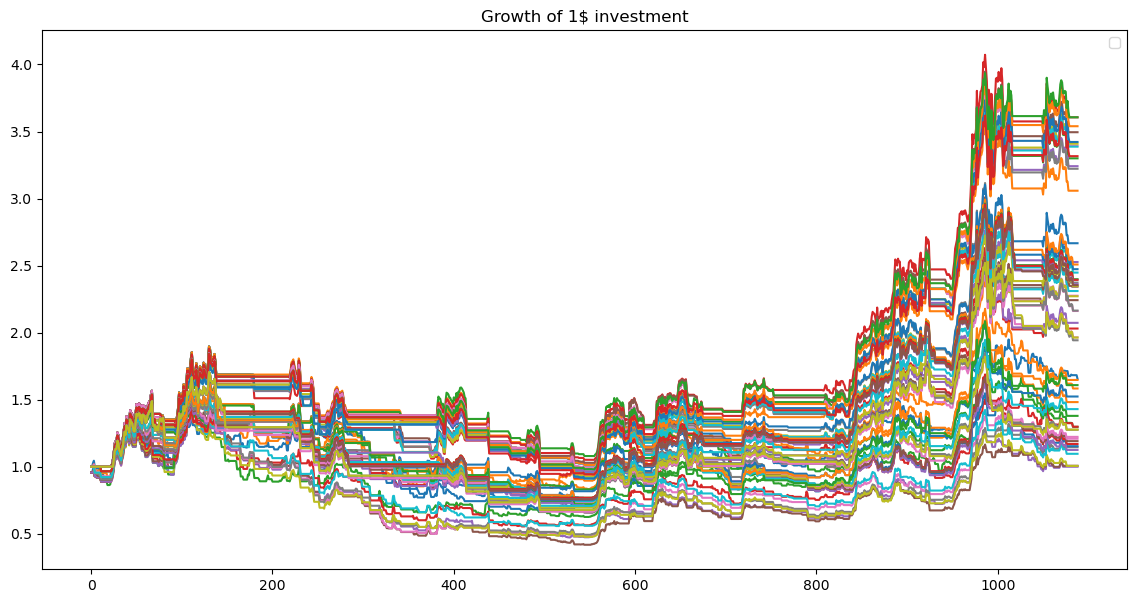

In [6]:
plt.figure(figsize=(14,7))
plt.title('Growth of 1$ investment')
for sma_period in range(2,61):
    plt.plot(np.exp(df[f'SMA_{sma_period}_log_returns']).cumprod())
# plt.plot(pd.Series(profits).dropna().cumprod(), c='blue', label='mr strategy')
plt.legend()

In [11]:
df[f'SMA_{sma_period}_log_returns']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1084    0.0
1085    0.0
1086    0.0
1087    0.0
1088    0.0
Name: SMA_60_log_returns, Length: 1089, dtype: float64

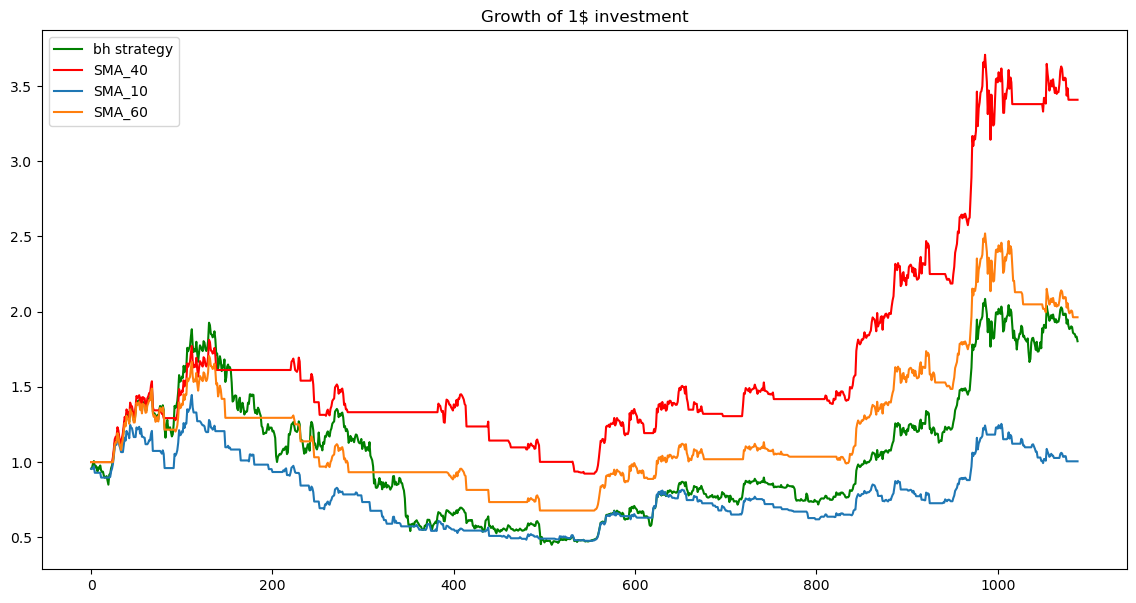

In [7]:
plt.figure(figsize=(14,7))
plt.title('Growth of 1$ investment')
plt.plot(np.exp(df['log_returns']).cumprod(), c='green', label='bh strategy')
plt.plot(np.exp(df['SMA_40_log_returns']).cumprod(), c='red', label='SMA_40')
plt.plot(np.exp(df['SMA_10_log_returns']).cumprod(), label='SMA_10')
plt.plot(np.exp(df['SMA_60_log_returns']).cumprod(), label='SMA_60')
# plt.plot(pd.Series(profits).dropna().cumprod(), c='blue', label='mr strategy')
plt.legend()

In [7]:
df['retorno_acumulado_rev_media_SMA40_1h'] = np.exp(df['SMA_40_log_returns'].dropna()).cumprod()
df['retorno_acumulado_bh'] = np.exp(df['log_returns'].dropna()).cumprod()

In [12]:
print(list(df.columns))

['timestamp_ms', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore', 'timestamp', 'returns', 'log_returns', 'SMA_2', 'SMA_2_in_position', 'SMA_2_log_returns', 'SMA_3', 'SMA_3_in_position', 'SMA_3_log_returns', 'SMA_4', 'SMA_4_in_position', 'SMA_4_log_returns', 'SMA_5', 'SMA_5_in_position', 'SMA_5_log_returns', 'SMA_6', 'SMA_6_in_position', 'SMA_6_log_returns', 'SMA_7', 'SMA_7_in_position', 'SMA_7_log_returns', 'SMA_8', 'SMA_8_in_position', 'SMA_8_log_returns', 'SMA_9', 'SMA_9_in_position', 'SMA_9_log_returns', 'SMA_10', 'SMA_10_in_position', 'SMA_10_log_returns', 'SMA_11', 'SMA_11_in_position', 'SMA_11_log_returns', 'SMA_12', 'SMA_12_in_position', 'SMA_12_log_returns', 'SMA_13', 'SMA_13_in_position', 'SMA_13_log_returns', 'SMA_14', 'SMA_14_in_position', 'SMA_14_log_returns', 'SMA_15', 'SMA_15_in_position', 'SMA_15_log_returns', 'SMA_16', 'SMA_16_in_position', 'SMA_16_l

In [8]:
df[['timestamp_ms','close','returns','log_returns', 'SMA_40_in_position', 'SMA_40_log_returns', 'retorno_acumulado_rev_media_SMA40_1h', 'retorno_acumulado_bh']].to_csv('data/resultados/rev_media_1h.csv')

In [10]:
df['close','returns','log_returns','signals',in_position,strategy_log_returns,retorno_acumulado_autobnn,retorno_acumulado_bh]

NameError: name 'in_position' is not defined

In [ ]:
np.exp(df['strategy_log_returns']).cumprod()[-1:].values[0]


KeyError: 'strategy_log_returns'

In [ ]:
results = []
for i in range(2,60):
    sma_period = i
    df = full_df.copy(deep=True)
    df['SMA'] = df['close'].rolling(sma_period).mean()
    df.dropna(inplace=True)
    df = df.reset_index(drop=True)
    first_buy = pd.Series(df.index == (df['close'] > df['SMA']).idxmax(),index=df.index)
    trades_df = df[first_buy | (df['close'] > df['SMA']).diff()]
    if trades_df.shape[0] % 2 != 0:
        mtm = df.iloc[-1:,]
        trades_df = pd.concat([trades_df,mtm], axis='index')
    get_strategy_log_returns(df, trades_df.index)
    
    end_return = np.exp(df['strategy_log_returns']).cumprod()[-1:].values[0]
    results.append({
        "periodo_media_movel": sma_period,
        "retorno_final": end_return
    })
results_df = pd.DataFrame(results)
results_df
    

TypeError: get_strategy_log_returns() missing 1 required positional argument: 'strategy_name'

<BarContainer object of 58 artists>

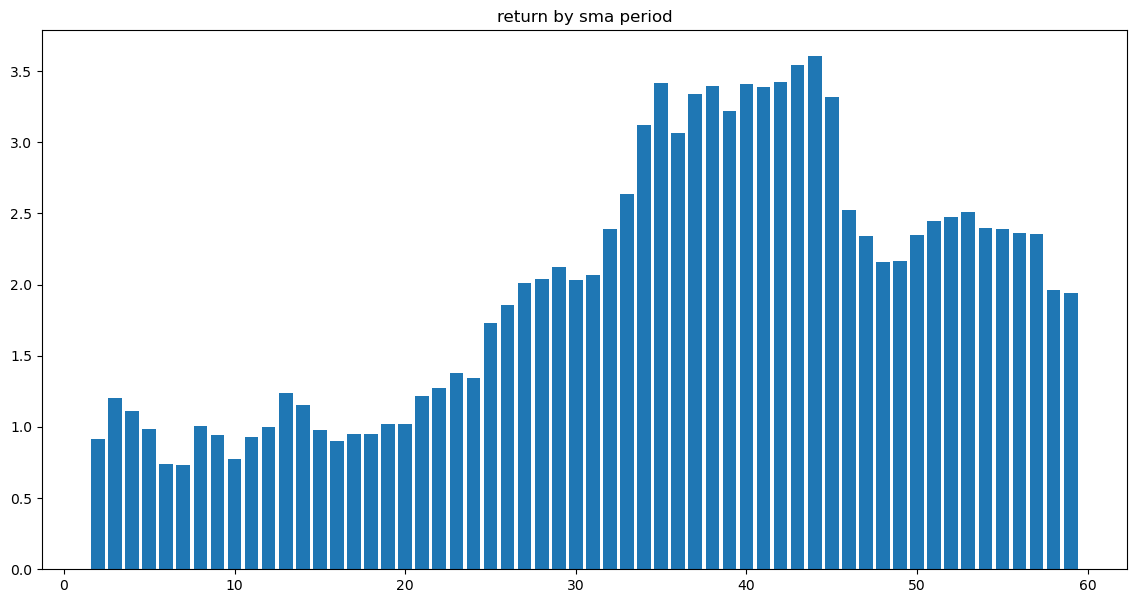

In [ ]:
plt.figure(figsize=(14,7))
plt.title('return by sma period')
plt.bar(results_df['periodo_media_movel'], height=results_df['retorno_final'])

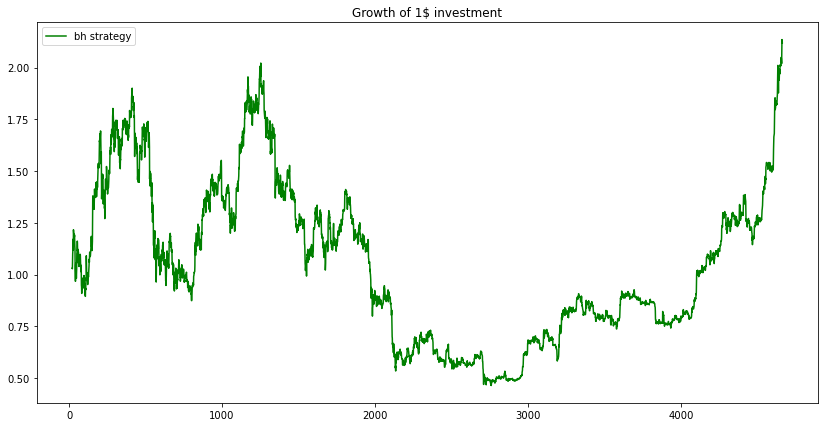

In [ ]:
plt.figure(figsize=(14,7))
plt.title('Growth of 1$ investment')
plt.plot(np.exp(df['log_returns'].dropna()).cumprod(), c='green', label='bh strategy')
# plt.plot(pd.Series(profits).dropna().cumprod(), c='blue', label='mr strategy')
plt.legend()

In [ ]:
(list(df['close'])[-1] - list(df['close'])[0])/list(df['close'])[0] - 1

0.45556260956985994

In [ ]:
dt_start = '2021.1.1'
dt_end = '2024.3.12'
frequencia_fonte = ['1d', '12h', '6h', '1h', '30m']
sma_windows = range(3,30)
results = []
for freq in frequencia_fonte:
    for window in sma_windows:
        df = pd.read_csv(rf'data\binance\{dt_start}_{dt_end}\bitcoin_{freq}_{dt_start}_{dt_end}.csv')
        df['SMA'] = df['close'].rolling(window).mean()
        df.dropna(inplace=True)
        #em criptos, diferente de acoes, o close de ontem é a mesma coisa que o open de hoje, entao nao precisaria dessa linha
        df['price'] = df['open'].shift(-1)
        first_buy = pd.Series(df.index == (df['close'] > df['SMA']).idxmax(),index=df.index)
        trades = df[first_buy | (df['close'] > df['SMA']).diff()]['price']
        if len(trades) % 2 != 0:
            mtm = df['close'][-1:]
            trades = pd.concat([trades,mtm])
        buys = trades[::2]
        sells = trades[1::2]
        profits = (sells.values - buys.values)/buys.values
        total_profit = (profits + 1).prod() - 1
        lucro_bh = (list(df['close'])[-1] - list(df['close'])[0])/list(df['close'])[0] - 1
        results.append({
            'frequencia_fonte': freq,
            'periodo_considerado': window,
            'lucro_bh': lucro_bh,
            'lucro_rm': total_profit
        })
results_df = pd.DataFrame(results)


In [ ]:
pd.set_option('display.max_rows', None)
results_df.sort_values(by='lucro_rm')

,frequencia_fonte,periodo_considerado,lucro_bh,lucro_rm
108,30m,3,0.458639,-0.633766
122,30m,17,0.455831,-0.469878
109,30m,4,0.468105,-0.468908
119,30m,14,0.469634,-0.455994
121,30m,16,0.467808,-0.447693
118,30m,13,0.471423,-0.412662
120,30m,15,0.467986,-0.393464
123,30m,18,0.460259,-0.392115
115,30m,10,0.478919,-0.373759
116,30m,11,0.483951,-0.335021
